#### SIADS 696 Milestone II

In [435]:
import pandas as pd
import numpy as np
from data_columns import childhood, demographic, diagnosis, all
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
import umap.umap_ as umap
import warnings
warnings.filterwarnings("ignore")


In [436]:
init_df = pd.read_csv('./data/mental-health-comorbidity-raw.csv')
init_df.shape

(5001, 1000)

In [437]:
df = init_df[all()].copy()
df = df.replace(-9, np.nan)
df = df.dropna()
df.shape

(4959, 122)

In [438]:
columns2 = demographic() + childhood() + ['DSM_DRA']
num_columns = ["HHSIZE","AGE"] + ["CH13","CH14","CH16","CH21","CH22","CH24","CH38","CH43","CH45"]
child_df = df[columns2].copy()

child_df = child_df.replace(-9, np.nan)
child_df = child_df.dropna()

cat_columns = [col for col in child_df.columns if col not in num_columns]
child_df[cat_columns] = child_df[cat_columns].astype('category')
df[num_columns] = df[num_columns].astype(int)


In [439]:
X = child_df.drop(columns=['DSM_DRA'])
y = child_df['DSM_DRA']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

model = GaussianNB()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.13      0.35      0.19        80
           5       0.93      0.80      0.86       912

    accuracy                           0.77       992
   macro avg       0.53      0.58      0.53       992
weighted avg       0.87      0.77      0.81       992



In [440]:
cat_columns = [col for col in cat_columns if col != 'DSM_DRA']

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_columns),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_columns)
])

pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("sampler", RandomOverSampler(random_state=42)),
    ("classifier", RandomForestClassifier(random_state=42))
    # ("classifier", LogisticRegression(solver="saga", max_iter=500))
    # ("classifier", GaussianNB())
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(pipeline, X, y, cv=cv, scoring="f1_macro")
print("Cross-val F1 scores:", scores)
print("Mean F1 score:", scores.mean())

Cross-val F1 scores: [0.48008386 0.4795383  0.4795383  0.4795383  0.48006296]
Mean F1 score: 0.47975234336674877


In [441]:
X_cluster = X.copy()

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_columns),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_columns)
])

X_preprocessed = preprocessor.fit_transform(X_cluster)

In [442]:
pca = PCA(n_components=3) 
X_pca = pca.fit_transform(X_preprocessed)

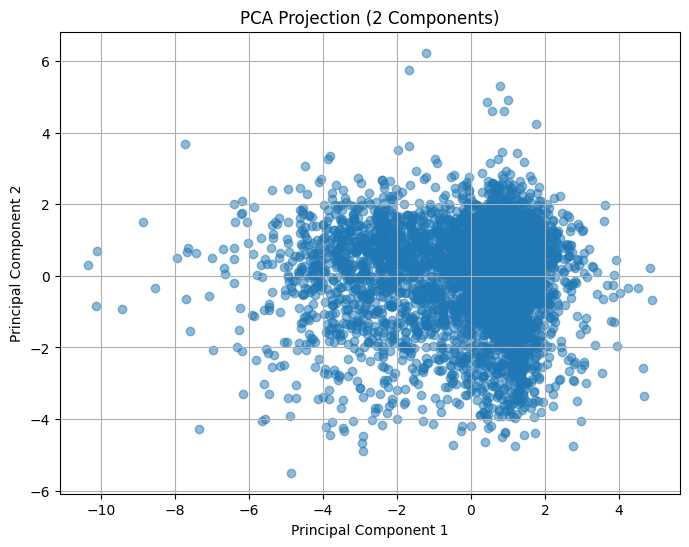

In [443]:
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5)
plt.title("PCA Projection (2 Components)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()

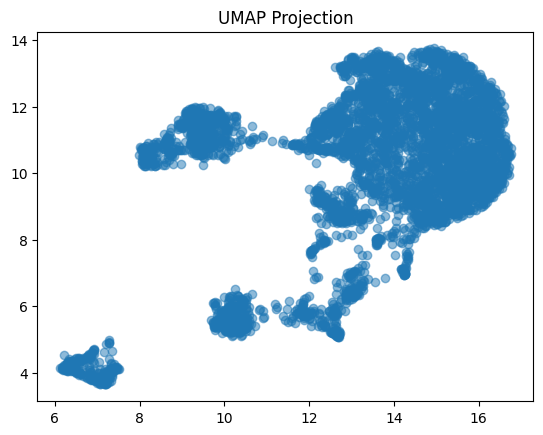

In [453]:
umap_model = umap.UMAP(random_state=42)
X_umap = umap_model.fit_transform(X_preprocessed)

plt.scatter(X_umap[:, 0], X_umap[:, 1], alpha=0.5)
plt.title("UMAP Projection")
plt.show()

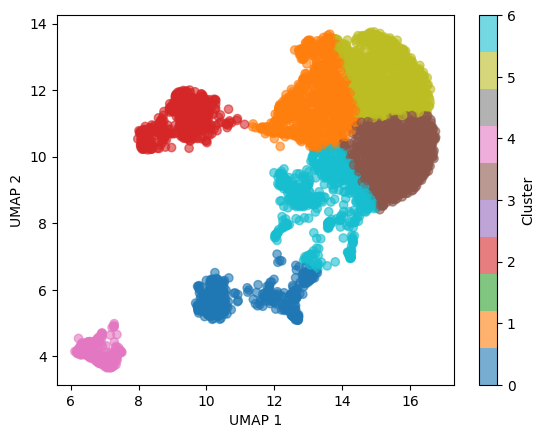

In [454]:
kmeans = KMeans(n_clusters=7, random_state=42)
labels = kmeans.fit_predict(X_umap)

plt.scatter(X_umap[:, 0], X_umap[:, 1], c=labels, cmap='tab10', alpha=0.6)
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.colorbar(label="Cluster")
plt.show()

In [457]:
X_clustered = X.copy()
X_clustered["cluster"] = labels
X_clustered.columns

Index(['REGION', 'HHSIZE', 'RESEX', 'AGE', 'AGECAT', 'EDUCAT', 'MARCAT',
       'EMPCAT', 'PEREARN2', 'SPEARN2', 'OTHINC2', 'HHINCOME2', 'INCPERCAP2',
       'INC_CAT', 'CH1', 'CH1A', 'CH9', 'CH9A', 'CH13', 'CH14', 'CH16', 'CH21',
       'CH22', 'CH24', 'CH37A', 'CH37B', 'CH37C', 'CH37D', 'CH37E', 'CH38',
       'CH38_1', 'CH39', 'CH42', 'CH43', 'CH44', 'CH45', 'CH46', 'CH47_1',
       'CH47_2', 'CH47_3', 'CH47_4', 'CH52', 'CH52A', 'CH60', 'CH60A', 'CH61',
       'CH61A', 'CH62', 'CH74', 'CH74_1', 'CH74_2', 'CH74_2A', 'CH74_2B',
       'CH74_2C', 'CH74_2D', 'CH74_2E', 'CH74_2F', 'CH75', 'CH76', 'CH76_1',
       'CH76_2', 'CH76_3', 'CH76_4', 'CH81', 'CH81A', 'CH89', 'CH89A', 'CH90',
       'CH90A', 'CH91', 'CH103', 'CH104', 'CH105', 'CH105A', 'CH105B',
       'CH105C', 'CH105D', 'CH105E', 'CH105F', 'cluster'],
      dtype='object')

In [459]:
X_clustered.groupby("cluster")[num_columns].describe()['AGE']

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0,530.0,40.756604,10.610798,25.0,32.0,39.0,48.0,65.0
1,958.0,45.659708,11.424417,25.0,36.0,46.0,55.0,69.0
2,587.0,46.826235,10.091922,25.0,39.0,46.0,54.5,67.0
3,1043.0,37.179291,6.945460,25.0,32.0,36.0,42.5,60.0
4,265.0,41.343396,10.816260,25.0,32.0,40.0,50.0,66.0
5,998.0,48.449900,8.407321,25.0,43.0,49.0,54.0,65.0
6,578.0,38.901384,9.808511,25.0,31.0,37.0,45.0,65.0


In [468]:
X_clustered.groupby("cluster")['EDUCAT'].value_counts().unstack()

EDUCAT,1.0,2.0,3.0,4.0
cluster,,,,
0,66,166,194,104
1,103,241,278,336
2,92,181,165,149
3,75,317,328,323
4,61,88,73,43
5,30,219,269,480
6,96,202,171,109


<Axes: xlabel='cluster'>

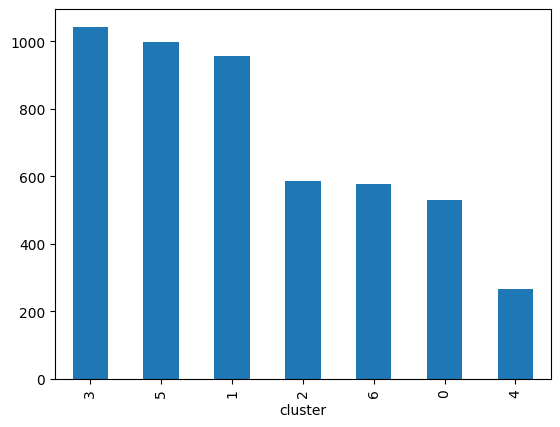

In [455]:
X_2 = X_clustered.drop(columns=['cluster'])
y_2 = X_clustered['cluster']
cat_columns = [col for col in cat_columns if col != 'DSM_PEA']

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_columns),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_columns)
])

pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(random_state=42))
    # ("classifier", LogisticRegression(solver="saga", max_iter=500))
])
y_2.value_counts().plot(kind='bar')

In [448]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(pipeline, X_2, y_2, cv=cv, scoring="f1_macro")
print("Cross-val F1 scores:", scores)
print("Mean F1 score:", scores.mean())

Cross-val F1 scores: [0.89160907 0.87161321 0.87864402 0.8782506  0.88342087]
Mean F1 score: 0.8807075509814881


In [450]:
dbscan = DBSCAN(eps=0.5, min_samples=100)
labels = dbscan.fit_predict(X_umap)

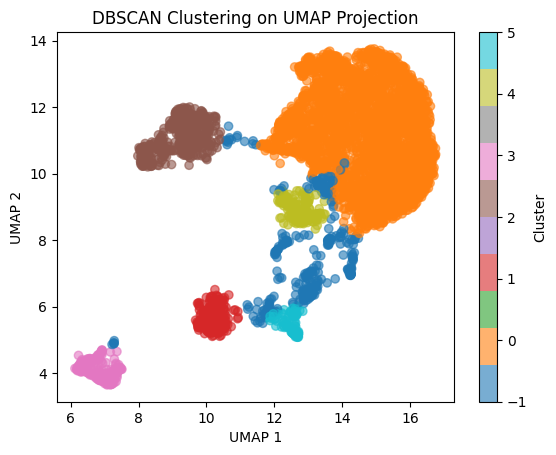

In [451]:
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=labels, cmap="tab10", alpha=0.6)
plt.title("DBSCAN Clustering on UMAP Projection")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.colorbar(label="Cluster")
plt.show()